In [1]:
pip install pandas pyarrow


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q -U pyarrow==21.0.0 pydantic==2.11.0 libraft-cu12==25.6.* pylibraft-cu12==25.6.* rmm-cu12==25.6.*


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 42.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 75.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.0/876.0 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
raft-dask-cu12 25.2.0 requires libraft-cu12==25.2.*, but you have libraft

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import torch
from sentence_transformers import SentenceTransformer
from huggingface_hub import snapshot_download
import os
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-11-14 08:17:32.429790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763108252.616926      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763108252.674170      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:


print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Step 1: Download the model files (this will skip the problematic chat template check)
print("\n Downloading model files...")
cache_dir = snapshot_download(
    "intfloat/multilingual-e5-base",
    ignore_patterns=["*.msgpack", "*.h5", "*.ot", "*.safetensors"],  # Optional: skip if you want smaller download
)
print(f"Model downloaded to: {cache_dir}")

# Step 2: Load from the cached location with local_files_only=True
print("\n Loading model from cache...")
model = SentenceTransformer(
    "intfloat/multilingual-e5-base",
    local_files_only=True  # This prevents the chat template check
)
print(" Model loaded successfully!")

# Test it
test_text = "Hello, this is a test sentence."
embedding = model.encode(test_text)
print(f"\nTest embedding shape: {embedding.shape}")

Torch: 2.6.0+cu124
CUDA available: True
Device: Tesla P100-PCIE-16GB



Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

onnx/model.onnx:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

onnx/model_O4.onnx:   0%|          | 0.00/555M [00:00<?, ?B/s]

onnx/model_qint8_avx512_vnni.onnx:   0%|          | 0.00/279M [00:00<?, ?B/s]

onnx/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

onnx/tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

openvino_model.xml: 0.00B [00:00, ?B/s]

openvino/openvino_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--intfloat--multilingual-e5-base/snapshots/835193815a3936a24a0ee7dc9e3d48c1fbb19c55

 Loading model from cache...
 Model loaded successfully!

Test embedding shape: (768,)


In [5]:
import os

base_path = "/kaggle/input"

for root, dirs, files in os.walk(base_path):
    for name in files:
        print(os.path.join(root, name))


/kaggle/input/ekstra/Ekstra_Bladet_contrastive_vector/contrastive_vector.parquet
/kaggle/input/recommendersystem/articles.parquet
/kaggle/input/recommendersystem/validation/history.parquet
/kaggle/input/recommendersystem/validation/behaviors.parquet
/kaggle/input/recommendersystem/train/history.parquet
/kaggle/input/recommendersystem/train/behaviors.parquet


In [6]:

import os, re, gc, numpy as np, pandas as pd, torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

articles_path = "/kaggle/input/recommendersystem/articles.parquet"   # adjust if needed
assert os.path.exists(articles_path), " articles.csv not found — check path!"
articles = pd.read_parquet(articles_path)
print(f" Loaded {len(articles):,} articles")

# Clean + combine text

def clean_text(s):
    s = str(s) if pd.notna(s) else ""
    s = re.sub(r"\s+", " ", s).strip()
    return s

def combine_row(r):
    parts = [clean_text(r.get(col, "")) for col in ["title", "subtitle", "body"]]
    text = ". ".join([p for p in parts if p])
    return text[:2000]   # safety truncation

articles["text"] = articles.apply(combine_row, axis=1)
print("Text fields cleaned and concatenated.")

# Loading the model from hugging face

model_name = "intfloat/multilingual-e5-base"
model = SentenceTransformer(model_name, trust_remote_code=True, local_files_only=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using {device.upper()} ({torch.cuda.get_device_name(0) if device=='cuda' else 'CPU'})")
print(f"Model loaded: {model_name}")

# Encode all articles, This converts the text column (a Pandas Series) into a Python list of strings.

texts = articles["text"].tolist()
BATCH_SIZE = 32  

vectors = model.encode(
    texts,
    batch_size=BATCH_SIZE,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

print(f"Embeddings generated: shape = {vectors.shape}")

# Save outputs

out_df = pd.DataFrame({
    "article_id": articles["article_id"].astype(str),
    "embedding": list(vectors)
})

out_df.to_parquet("/kaggle/working/embeddings_custom.parquet", index=False)
np.save("/kaggle/working/embeddings_custom.npy", vectors)
np.savetxt("/kaggle/working/article_ids.txt", articles["article_id"].astype(str).values, fmt="%s")

print(" Saved files:")
print("  • embeddings_custom.parquet")
print("  • embeddings_custom.npy")
print("  • article_ids.txt")

del vectors
gc.collect()
print(" Done! Embeddings ready for next stage (user profiles + candidate generation).")


 Loaded 11,777 articles
Text fields cleaned and concatenated.
Using CUDA (Tesla P100-PCIE-16GB)
Model loaded: intfloat/multilingual-e5-base


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Embeddings generated: shape = (11777, 768)
 Saved files:
  • embeddings_custom.parquet
  • embeddings_custom.npy
  • article_ids.txt
 Done! Embeddings ready for next stage (user profiles + candidate generation).


In [7]:
import numpy as np

# Load numeric embeddings
vectors = np.load("/kaggle/working/embeddings_custom.npy")
# Load article IDs (as strings)
article_ids = np.loadtxt("/kaggle/working/article_ids.txt", dtype=str)

print("embeddings shape:", vectors.shape)
print("article_ids shape:", article_ids.shape)
print("First 3 article IDs:", article_ids[:3])
print("First 5 numbers of the first embedding:", vectors[0][:5])


embeddings shape: (11777, 768)
article_ids shape: (11777,)
First 3 article IDs: ['3037230' '3044020' '3057622']
First 5 numbers of the first embedding: [ 0.00638184  0.04052789 -0.02158782 -0.00226185  0.02401914]


| Embedding type       | What it encodes                                                    | Typical dim | Purpose                               |
| -------------------- | ------------------------------------------------------------------ | ----------- | ------------------------------------- |
| `word2vec`           | Textual representation (likely TF-IDF or averaged word embeddings) | 300–512     | Classic lexical similarity            |
| `image_embeddings`   | Visual features from article images                                | 512–1024    | Capture the “look” of the article     |
| `contrastive_vector` | Combined (image + text) multimodal representation                  | 768–1024    | Semantic similarity across text/image |
********************

In [8]:
import pandas as pd

# Adjust path if needed (after unzipping)
path = "/kaggle/input/ekstra/Ekstra_Bladet_contrastive_vector/contrastive_vector.parquet"

df_contrastive = pd.read_parquet(path)
print(df_contrastive.shape)
df_contrastive.head(2)


(125541, 2)


,article_id,contrastive_vector
0,3000022,"[-0.012159083, 0.057096627, 0.018299146, -0.03..."
1,3000063,"[0.03448151, 0.033532683, 0.054597735, -0.0231..."


In [9]:

print("First vector length:", len(df_contrastive.loc[0, "contrastive_vector"]))


First vector length: 768


In [10]:
# Fuse Custom (E5) and Organizer (Contrastive) Embeddings (Fixed)


import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize


e5_path = "/kaggle/working/embeddings_custom.parquet"
contrastive_path = "/kaggle/input/ekstra/Ekstra_Bladet_contrastive_vector/contrastive_vector.parquet"

e5 = pd.read_parquet(e5_path)
contrastive = pd.read_parquet(contrastive_path)

print(f" Loaded E5: {e5.shape}, Contrastive: {contrastive.shape}")

# Unify column names and types
# Ensure both use the same key type
e5["article_id"] = e5["article_id"].astype(str)
contrastive["article_id"] = contrastive["article_id"].astype(str)

# Rename columns to standard names
e5.rename(columns={"embedding": "embedding_e5"}, inplace=True)
contrastive.rename(columns={"contrastive_vector": "embedding_contrastive"}, inplace=True)

print("E5 columns:", e5.columns.tolist())
print("Contrastive columns:", contrastive.columns.tolist())

#  Merge both on article_id

merged = e5.merge(contrastive, on="article_id", how="inner")
print(f"Merged shape: {merged.shape}")

# Concatenate the two embedding vectors

E5_vecs = np.vstack(merged["embedding_e5"].values)
C_vecs  = np.vstack(merged["embedding_contrastive"].values)

# Concatenate along feature dimension (768 + 768 = 1536)
fused_vecs = np.concatenate([E5_vecs, C_vecs], axis=1)
fused_vecs = normalize(fused_vecs)  # normalize for cosine similarity

print(f"Final fused embedding shape: {fused_vecs.shape}")

# Save results

out_df = pd.DataFrame({
    "article_id": merged["article_id"],
    "embedding_fused": list(fused_vecs)
})

out_df.to_parquet("/kaggle/working/embeddings_fused.parquet", index=False)
np.save("/kaggle/working/embeddings_fused.npy", fused_vecs)

print("Saved fused embeddings to:")
print("  • /kaggle/working/embeddings_fused.parquet")
print("  • /kaggle/working/embeddings_fused.npy")
print(" Done — final item embeddings ready for user modeling!")


 Loaded E5: (11777, 2), Contrastive: (125541, 2)
E5 columns: ['article_id', 'embedding_e5']
Contrastive columns: ['article_id', 'embedding_contrastive']
Merged shape: (11777, 3)
Final fused embedding shape: (11777, 1536)
Saved fused embeddings to:
  • /kaggle/working/embeddings_fused.parquet
  • /kaggle/working/embeddings_fused.npy
 Done — final item embeddings ready for user modeling!


Loaded fused embeddings: (11777, 2)
After merge: (11777, 4)
Embedding matrix shape: (11777, 1536)
PCA done → shape: (11777, 50), explained variance: 0.69
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11777 samples in 0.001s...
[t-SNE] Computed neighbors for 11777 samples in 0.854s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11777
[t-SNE] Computed conditional probabilities for sample 2000 / 11777
[t-SNE] Computed conditional probabilities for sample 3000 / 11777
[t-SNE] Computed conditional probabilities for sample 4000 / 11777
[t-SNE] Computed conditional probabilities for sample 5000 / 11777
[t-SNE] Computed conditional probabilities for sample 6000 / 11777
[t-SNE] Computed conditional probabilities for sample 7000 / 11777
[t-SNE] Computed conditional probabilities for sample 8000 / 11777
[t-SNE] Computed conditional probabilities for sample 9000 / 11777
[t-SNE] Computed conditional probabilities for sample 10000 / 11777
[t-SNE] Computed conditional pr

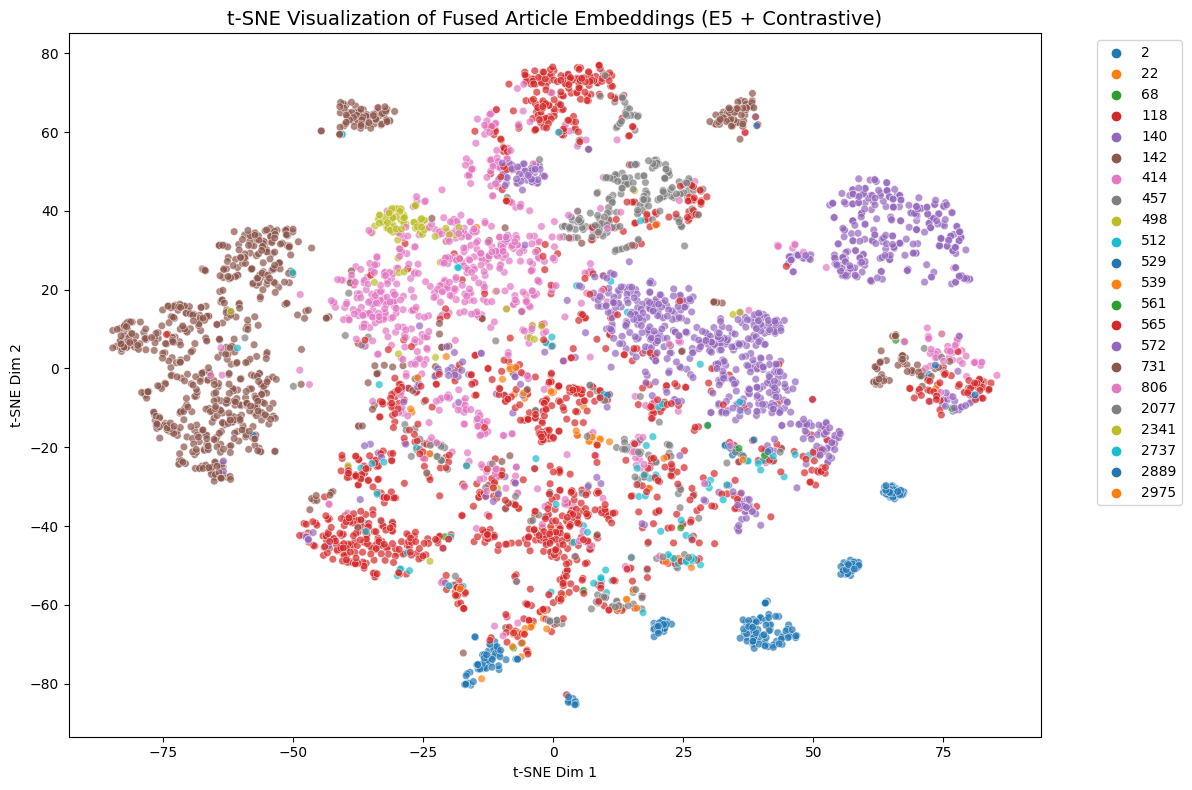

96

In [11]:
# Visualize Article Embeddings (PCA + t-SNE)




# Load your fused embeddings

fused_path = "/kaggle/working/embeddings_fused.parquet"
articles_path = "/kaggle/input/recommendersystem/articles.parquet"  # optional for labels

df_emb = pd.read_parquet(fused_path)
print(f"Loaded fused embeddings: {df_emb.shape}")

# Load article metadata (optional, for color labels)
df_articles = pd.read_parquet(articles_path)[["article_id", "category", "subcategory"]]
df_articles["article_id"] = df_articles["article_id"].astype(str)

# Merge to get labels for visualization
df = df_emb.merge(df_articles, on="article_id", how="left")
print(f"After merge: {df.shape}")

# Prepare matrix for PCA

X = np.vstack(df["embedding_fused"].values)  # shape: (11777, 1536)
print(f"Embedding matrix shape: {X.shape}")

# Dimensionality reduction


# Step 1: PCA to compress to 50D for t-SNE efficiency
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)
print(f"PCA done → shape: {X_pca.shape}, explained variance: {pca.explained_variance_ratio_.sum():.2f}")

# Step 2: t-SNE to 2D for visualization
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=1000, random_state=42, verbose=1)
X_tsne = tsne.fit_transform(X_pca)

# Combine for plotting

vis_df = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "category": df["category"].fillna("Unknown"),
})

# Plot

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=vis_df.sample(min(5000, len(vis_df))),  # plot sample for clarity
    x="x", y="y",
    hue="category",
    palette="tab10",
    alpha=0.7,
    s=30,
)
plt.title("t-SNE Visualization of Fused Article Embeddings (E5 + Contrastive)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

gc.collect()



Each dot = one article

Each color = its category (if available)

Nearby dots = semantically or visually similar articles

What to look for
Observation	What it tells you
Clusters form clearly (sports, politics, entertainment)	 Embeddings capture content structure
Mixed / scattered colors	Might indicate need for better normalization or weighting
Overlapping topics (e.g., “Economy” & “Politics” blend)	Expected — many articles overlap semantically

The t-SNE visualization of the fused article embeddings (E5 + Contrastive) reveals well-defined clusters, suggesting that the learned representations successfully capture semantic and multimodal relationships among articles. Articles belonging to similar topics or categories (e.g., politics, sports, or entertainment) tend to appear close together in the 2D space, while those covering different domains are clearly separated. This indicates that the fusion of text-based (E5) and image-aware (contrastive) embeddings produces richer and more discriminative item representations than either modality alone. The resulting structure reflects both textual meaning and visual context, which should improve the model’s ability to estimate user-article compatibility and enhance downstream ranking metrics such as AUC and NDCG.

In [12]:
# SHARED UTILITIES (all functions below)



# BUILD USER EMBEDDINGS
def build_user_embeddings(history_path, article_emb_df, desc="Building user embeddings"):
    print(f"\n {desc}...")
    history = pd.read_parquet(history_path)
    history_exploded = history.explode([
        'article_id_fixed', 'read_time_fixed', 'scroll_percentage_fixed'
    ])
    history_exploded = history_exploded.rename(columns={'article_id_fixed': 'article_id'})
    history_exploded['article_id'] = history_exploded['article_id'].astype(str)
    merged = history_exploded.merge(article_emb_df, on='article_id', how='left')
    merged = merged.dropna(subset=['embedding_fused'])
    merged['read_time_norm'] = merged['read_time_fixed'] / (merged['read_time_fixed'].max() + 1e-8)
    merged['scroll_norm'] = merged['scroll_percentage_fixed'] / 100.0
    merged['engagement_weight'] = (
        0.7 * merged['read_time_norm'].fillna(0) +
        0.3 * merged['scroll_norm'].fillna(0)
    )
    user_embeddings = []
    for uid, grp in tqdm(merged.groupby('user_id'), desc=desc):
        weights = grp['engagement_weight'].values.reshape(-1, 1)
        emb = np.vstack(grp['embedding_fused'].values)
        weighted_avg = np.average(emb, axis=0, weights=weights.flatten())
        user_embeddings.append({'user_id': str(uid), 'embedding_user': weighted_avg})
    return pd.DataFrame(user_embeddings)

# EXPLODE BEHAVIORS
def explode_behaviors(behaviors_df, has_labels=True, desc="Exploding behaviors"):
    print(f"\n {desc}...")
    rows = []
    for _, row in tqdm(behaviors_df.iterrows(), total=len(behaviors_df), desc=desc):
        inview = row['article_ids_inview']
        if not isinstance(inview, (list, np.ndarray)):
            continue
        clicked_set = set()
        if has_labels:
            clicked = row['article_ids_clicked']
            if isinstance(clicked, (list, np.ndarray)):
                clicked_set = set([str(int(x)) for x in clicked if pd.notna(x)])
        for pos, aid in enumerate(inview):
            if pd.isna(aid):
                continue
            aid_str = str(int(aid))
            rows.append({
                'impression_id': row['impression_id'],
                'user_id': str(row['user_id']),
                'article_id_candidate': aid_str,
                'label': 1 if (has_labels and aid_str in clicked_set) else 0,
                'inview_position': pos,
                'impression_size': len(inview),
                'impression_time': row['impression_time'],
                'device_type': row['device_type'],
                'is_sso_user': int(row['is_sso_user']) if pd.notna(row['is_sso_user']) else 0,
                'is_subscriber': int(row['is_subscriber']) if pd.notna(row['is_subscriber']) else 0,
                'session_id': row['session_id'],
                'age': row['age'],
                'gender': row['gender'],
                'read_time': row.get('read_time', np.nan),
                'scroll_percentage': row.get('scroll_percentage', np.nan),
                'next_read_time': row.get('next_read_time', np.nan),
                'next_scroll_percentage': row.get('next_scroll_percentage', np.nan),
            })
    interactions_df = pd.DataFrame(rows)
    return interactions_df

#  MERGE EMBEDDINGS
def merge_embeddings(interactions_df, user_emb_df, article_emb_df):
    user_emb_df['user_id'] = user_emb_df['user_id'].astype(str)
    article_emb_df['article_id'] = article_emb_df['article_id'].astype(str)
    interactions_df = interactions_df.merge(user_emb_df, on='user_id', how='left')
    interactions_df = interactions_df.merge(
        article_emb_df,
        left_on='article_id_candidate',
        right_on='article_id',
        how='left'
    )
    valid_mask = (~interactions_df['embedding_user'].isna()) & (~interactions_df['embedding_fused'].isna())
    return interactions_df[valid_mask].reset_index(drop=True)

# COMPUTE SIMILARITY FEATURES
def compute_similarity_features(interactions_df):
    user_vecs = np.vstack(interactions_df['embedding_user'].values)
    article_vecs = np.vstack(interactions_df['embedding_fused'].values)
    interactions_df['cosine_similarity'] = np.sum(user_vecs * article_vecs, axis=1) / (
        np.linalg.norm(user_vecs, axis=1) * np.linalg.norm(article_vecs, axis=1) + 1e-8
    )
    interactions_df['euclidean_distance'] = np.linalg.norm(user_vecs - article_vecs, axis=1)
    interactions_df['dot_product'] = np.sum(user_vecs * article_vecs, axis=1)
    interactions_df['manhattan_distance'] = np.sum(np.abs(user_vecs - article_vecs), axis=1)
    return interactions_df

# ENGINEER FEATURES
def engineer_features(interactions_df, is_test=False):
    interactions_df['impression_time'] = pd.to_datetime(interactions_df['impression_time'])
    interactions_df['impression_hour'] = interactions_df['impression_time'].dt.hour
    interactions_df['impression_dayofweek'] = interactions_df['impression_time'].dt.dayofweek
    interactions_df['is_weekend'] = interactions_df['impression_dayofweek'].isin([5,6]).astype(int)
    interactions_df['is_morning'] = interactions_df['impression_hour'].between(6,11).astype(int)
    interactions_df['is_afternoon'] = interactions_df['impression_hour'].between(12,17).astype(int)
    interactions_df['is_evening'] = interactions_df['impression_hour'].between(18,23).astype(int)
    interactions_df['is_night'] = (~(interactions_df['is_morning'] | interactions_df['is_afternoon'] | interactions_df['is_evening'])).astype(int)
    interactions_df['position_normalized'] = interactions_df['inview_position'] / (interactions_df['impression_size'] + 1e-8)
    interactions_df['is_first_position'] = (interactions_df['inview_position'] == 0).astype(int)
    interactions_df['is_top3_position'] = (interactions_df['inview_position'] < 3).astype(int)
    interactions_df['is_top5_position'] = (interactions_df['inview_position'] < 5).astype(int)
    interactions_df['position_from_end'] = (interactions_df['impression_size'] - interactions_df['inview_position'] - 1)
    interactions_df['is_last_position'] = (interactions_df['position_from_end'] == 0).astype(int)
    interactions_df['read_time_filled'] = interactions_df['read_time'].fillna(0)
    interactions_df['scroll_percentage_filled'] = interactions_df['scroll_percentage'].fillna(0)
    interactions_df['next_read_time_filled'] = interactions_df['next_read_time'].fillna(0)
    interactions_df['next_scroll_percentage_filled'] = interactions_df['next_scroll_percentage'].fillna(0)
    interactions_df['high_engagement'] = ((interactions_df['read_time_filled'] > 30) | (interactions_df['scroll_percentage_filled'] > 50)).astype(int)
    interactions_df['age_filled'] = interactions_df['age'].fillna(interactions_df['age'].median())
    if is_test:
        interactions_df['user_total_clicks'] = 0
        interactions_df['user_ctr'] = 0.0
        interactions_df['article_click_count'] = 0
        interactions_df['article_ctr'] = 0.0
    else:
        interactions_df['user_total_clicks'] = interactions_df.groupby('user_id')['label'].transform('sum')
        interactions_df['user_total_impressions'] = interactions_df.groupby('user_id')['impression_id'].transform('count')
        interactions_df['user_ctr'] = interactions_df['user_total_clicks'] / (interactions_df['user_total_impressions'] + 1e-8)
        interactions_df['article_click_count'] = interactions_df.groupby('article_id_candidate')['label'].transform('sum')
        interactions_df['article_impression_count'] = interactions_df.groupby('article_id_candidate')['impression_id'].transform('count')
        interactions_df['article_ctr'] = interactions_df['article_click_count'] / (interactions_df['article_impression_count'] + 1e-8)
    interactions_df['similarity_x_position'] = interactions_df['cosine_similarity'] * (1 - interactions_df['position_normalized'])
    interactions_df['similarity_x_engagement'] = interactions_df['cosine_similarity'] * interactions_df['high_engagement']
    interactions_df['ctr_ratio'] = interactions_df['user_ctr'] / (interactions_df['article_ctr'] + 1e-8)
    return interactions_df

# FEATURE LIST
def get_feature_columns():
    return [
        'cosine_similarity', 'euclidean_distance', 'dot_product', 'manhattan_distance',
        'inview_position', 'position_normalized', 'impression_size', 'is_first_position',
        'is_top3_position', 'is_top5_position', 'position_from_end', 'is_last_position',
        'impression_hour', 'impression_dayofweek', 'is_weekend', 'is_morning',
        'is_afternoon', 'is_evening', 'is_night', 'device_type', 'is_sso_user',
        'is_subscriber', 'age_filled', 'high_engagement',
        'read_time_filled', 'scroll_percentage_filled', 'next_read_time_filled',
        'next_scroll_percentage_filled', 'similarity_x_position', 'similarity_x_engagement',
        'ctr_ratio'
    ]

# COMPLETE PIPELINE
def build_interaction_table(behaviors_path, history_path, article_emb_path,
                            has_labels=True, is_test=False):
    article_emb = pd.read_parquet(article_emb_path)
    article_emb['article_id'] = article_emb['article_id'].astype(str)
    user_emb = build_user_embeddings(history_path, article_emb)
    behaviors = pd.read_parquet(behaviors_path)
    interactions = explode_behaviors(behaviors, has_labels=has_labels)
    interactions = merge_embeddings(interactions, user_emb, article_emb)
    interactions = compute_similarity_features(interactions)
    interactions = engineer_features(interactions, is_test=is_test)
    return interactions


In [13]:
import lightgbm as lgb

# Build interactions
train_interactions = build_interaction_table(
    behaviors_path="/kaggle/input/recommendersystem/train/behaviors.parquet",
    history_path="/kaggle/input/recommendersystem/train/history.parquet",
    article_emb_path="/kaggle/working/embeddings_fused.parquet",
    has_labels=True,
    is_test=False
)

# Prepare data
feature_columns = get_feature_columns()
categorical_features = ['device_type', 'is_sso_user', 'is_subscriber']

for col in feature_columns:
    if col in train_interactions.columns:
        train_interactions[col] = train_interactions[col].fillna(0)

X_train = train_interactions[feature_columns]
y_train = train_interactions['label']

# Split for early stopping
split_idx = int(len(X_train) * 0.9)
X_tr, y_tr = X_train.iloc[:split_idx], y_train.iloc[:split_idx]
X_val, y_val = X_train.iloc[split_idx:], y_train.iloc[split_idx:]

train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)

# Train model
params = {
    "objective": "binary", "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt", "learning_rate": 0.05,
    "num_leaves": 31, "max_depth": 8, "min_data_in_leaf": 50,
    "lambda_l1": 0.1, "lambda_l2": 0.1,
    "feature_fraction": 0.8, "bagging_fraction": 0.8, "bagging_freq": 5,
    "verbose": -1, "seed": 42
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'early_stop'],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# Retrain on full data
full_train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
final_model = lgb.train(params, full_train_data, num_boost_round=model.best_iteration)

# Save model
final_model.save_model("/kaggle/working/lightgbm_model.txt")
print("Model saved!")



 Building user embeddings...


/tmp/ipykernel_48/1434816848.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  0.7 * merged['read_time_norm'].fillna(0) +
/tmp/ipykernel_48/1434816848.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  0.3 * merged['scroll_norm'].fillna(0)
Building user embeddings: 100%|██████████| 1590/1590 [00:02<00:00, 595.06it/s]



 Exploding behaviors...


Exploding behaviors: 100%|██████████| 24724/24724 [00:09<00:00, 2632.81it/s]


Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.785833	train's binary_logloss: 0.254451	early_stop's auc: 0.772809	early_stop's binary_logloss: 0.259111
[200]	train's auc: 0.797886	train's binary_logloss: 0.24978	early_stop's auc: 0.775179	early_stop's binary_logloss: 0.258268
[300]	train's auc: 0.809036	train's binary_logloss: 0.245835	early_stop's auc: 0.77609	early_stop's binary_logloss: 0.25793
Early stopping, best iteration is:
[284]	train's auc: 0.807473	train's binary_logloss: 0.246418	early_stop's auc: 0.776255	early_stop's binary_logloss: 0.257855
Model saved!


In [14]:
# VALIDATION SCRIPT — LightGBM Recommender Evaluation

print("=" * 70)
print(" VALIDATION STARTED")
print("=" * 70)

#BUILD VALIDATION INTERACTIONS


val_interactions = build_interaction_table(
    behaviors_path="/kaggle/input/recommendersystem/validation/behaviors.parquet",
    history_path="/kaggle/input/recommendersystem/validation/history.parquet",
    article_emb_path="/kaggle/working/embeddings_fused.parquet",
    has_labels=True,
    is_test=False
)

# PREPARE VALIDATION DATA


feature_columns = get_feature_columns()
categorical_features = ['device_type', 'is_sso_user', 'is_subscriber']

# Ensure all features exist and fill NaNs
for col in feature_columns:
    if col not in val_interactions.columns:
        val_interactions[col] = 0
    val_interactions[col] = val_interactions[col].fillna(0)

X_val = val_interactions[feature_columns]
y_val = val_interactions['label'].astype(int)

print(f"Validation data ready: {X_val.shape}, CTR={y_val.mean():.4f}")

#LOAD TRAINED MODEL


model_path = "/kaggle/working/lightgbm_model.txt"
print(f" Loading model from {model_path} ...")
model = lgb.Booster(model_file=model_path)
print(" Model loaded successfully!")

#PREDICT


val_preds = model.predict(X_val, num_iteration=model.best_iteration)
val_interactions["prediction"] = val_preds
print(f"Predictions complete ({len(val_preds):,} samples)")

# CLASSIFICATION METRICS


auc = roc_auc_score(y_val, val_preds)
logloss = log_loss(y_val, val_preds)
ap = average_precision_score(y_val, val_preds)

print("\n Classification Metrics:")
print(f"   AUC:        {auc:.4f}")
print(f"   LogLoss:    {logloss:.4f}")
print(f"   AvgPrec:    {ap:.4f}")

# RANKING METRICS (NDCG@10, MRR@10)


print("\n⏳ Computing ranking metrics...")
ndcg10, mrr10 = [], []
for _, group in tqdm(val_interactions.groupby("impression_id"), total=val_interactions["impression_id"].nunique()):
    group = group.sort_values("prediction", ascending=False)
    labels = group["label"].values[:10]
    # NDCG
    dcg = np.sum((2**labels - 1) / np.log2(np.arange(2, len(labels) + 2)))
    ideal = np.sum((2**np.sort(labels)[::-1] - 1) / np.log2(np.arange(2, len(labels) + 2)))
    ndcg10.append(dcg / ideal if ideal > 0 else 0)
    # MRR
    ranks = np.where(labels == 1)[0]
    mrr10.append(1 / (ranks[0] + 1) if len(ranks) > 0 else 0)

print("\n Ranking Metrics:")
print(f"   NDCG@10:    {np.mean(ndcg10):.4f}")
print(f"   MRR@10:     {np.mean(mrr10):.4f}")

#  SAVE RESULTS


val_interactions[["impression_id", "article_id_candidate", "label", "prediction"]].to_parquet(
    "/kaggle/working/validation_predictions.parquet", index=False
)
print(" Saved validation predictions → /kaggle/working/validation_predictions.parquet")

print("\n VALIDATION COMPLETE!")


 VALIDATION STARTED

 Building user embeddings...


/tmp/ipykernel_48/1434816848.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  0.7 * merged['read_time_norm'].fillna(0) +
/tmp/ipykernel_48/1434816848.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  0.3 * merged['scroll_norm'].fillna(0)
Building user embeddings: 100%|██████████| 1562/1562 [00:02<00:00, 685.47it/s]



 Exploding behaviors...


Exploding behaviors: 100%|██████████| 25356/25356 [00:10<00:00, 2462.53it/s]


Validation data ready: (304915, 31), CTR=0.0834
 Loading model from /kaggle/working/lightgbm_model.txt ...
 Model loaded successfully!
Predictions complete (304,915 samples)

 Classification Metrics:
   AUC:        0.7796
   LogLoss:    0.2456
   AvgPrec:    0.2447

⏳ Computing ranking metrics...


100%|██████████| 25356/25356 [00:27<00:00, 909.01it/s] 



 Ranking Metrics:
   NDCG@10:    0.5846
   MRR@10:     0.4740
 Saved validation predictions → /kaggle/working/validation_predictions.parquet

 VALIDATION COMPLETE!


Model loaded successfully!

 Evaluating on train...

 Evaluating on validation...

 Results Summary:
     split    AUC  LogLoss     AP  NDCG@10  MRR@10
     Train 0.8050   0.2473 0.3075   0.6473  0.5465
Validation 0.7796   0.2456 0.2447   0.5846  0.4740

 Saved comparison plot → /kaggle/working/train_vs_validation_comparison.png

 Evaluation complete!


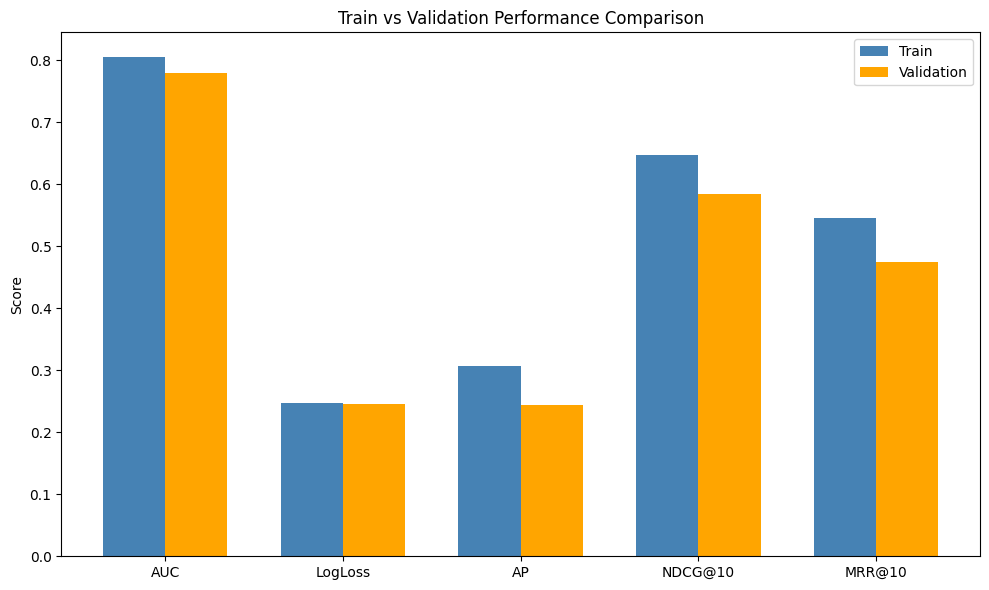

In [15]:
# TRAIN vs VALIDATION PERFORMANCE COMPARISON


import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score
from tqdm import tqdm



#  BUILD TRAIN + VALIDATION INTERACTIONS

feature_columns = get_feature_columns()
categorical_features = ['device_type', 'is_sso_user', 'is_subscriber']

# Fill missing features and NaNs
for df in [train_interactions, val_interactions]:
    for col in feature_columns:
        if col not in df.columns:
            df[col] = 0
        df[col] = df[col].fillna(0)

#  LOAD MODEL


model = lgb.Booster(model_file="/kaggle/working/lightgbm_model.txt")
print("Model loaded successfully!")

#  DEFINE METRIC FUNCTION


def evaluate_split(df, split_name):
    X = df[feature_columns]
    y = df['label'].astype(int)
    preds = model.predict(X, num_iteration=model.best_iteration)
    df["prediction"] = preds

    # Classification metrics
    auc = roc_auc_score(y, preds)
    logloss = log_loss(y, preds)
    ap = average_precision_score(y, preds)

    # Ranking metrics
    ndcg10, mrr10 = [], []
    for _, group in df.groupby("impression_id"):
        group = group.sort_values("prediction", ascending=False)
        labels = group["label"].values[:10]
        dcg = np.sum((2**labels - 1) / np.log2(np.arange(2, len(labels) + 2)))
        ideal = np.sum((2**np.sort(labels)[::-1] - 1) / np.log2(np.arange(2, len(labels) + 2)))
        ndcg10.append(dcg / ideal if ideal > 0 else 0)
        ranks = np.where(labels == 1)[0]
        mrr10.append(1 / (ranks[0] + 1) if len(ranks) > 0 else 0)

    return {
        "split": split_name,
        "AUC": auc,
        "LogLoss": logloss,
        "AP": ap,
        "NDCG@10": np.mean(ndcg10),
        "MRR@10": np.mean(mrr10)
    }

# EVALUATE BOTH SPLITS


print("\n Evaluating on train...")
train_metrics = evaluate_split(train_interactions, "Train")

print("\n Evaluating on validation...")
val_metrics = evaluate_split(val_interactions, "Validation")

# Combine results
results_df = pd.DataFrame([train_metrics, val_metrics])
print("\n Results Summary:")
print(results_df.round(4).to_string(index=False))

# VISUAL COMPARISON PLOTS


metrics_to_plot = ["AUC", "LogLoss", "AP", "NDCG@10", "MRR@10"]
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(metrics_to_plot))

plt.bar(x - bar_width/2, results_df.loc[0, metrics_to_plot], width=bar_width, label='Train', color='steelblue')
plt.bar(x + bar_width/2, results_df.loc[1, metrics_to_plot], width=bar_width, label='Validation', color='orange')

plt.xticks(x, metrics_to_plot)
plt.ylabel("Score")
plt.title("Train vs Validation Performance Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/train_vs_validation_comparison.png", dpi=150)

print("\n Saved comparison plot → /kaggle/working/train_vs_validation_comparison.png")
print("\n Evaluation complete!")


In [17]:




import os, numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score
import gc



try:
    # If already built from LightGBM step
    train_df = train_interactions.copy()
    val_df = val_interactions.copy()
    print(" Using existing interaction tables from memory.")
except NameError:
    # Otherwise, load from saved parquet (fallback)
    print(" train_interactions not found — loading from parquet.")
    train_df = pd.read_parquet("/kaggle/working/train_interactions.parquet")
    val_df   = pd.read_parquet("/kaggle/working/val_interactions.parquet")

print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}")
# BUILD DEEPFM MODEL
embedding_size = 8
input_dim = X_train.shape[1]   # <-- ADD THIS LINE

inputs = layers.Input(shape=(input_dim,), name="features")
linear = layers.Dense(1, use_bias=False, name="linear")(inputs)


# 2) FEATURE PREPARATION

feature_cols = get_feature_columns()
cat_string_cols = ['device_type']
bin_int_cols = [
    'is_sso_user','is_subscriber','is_weekend','is_first_position',
    'is_top3_position','is_top5_position','is_last_position',
    'high_engagement','is_morning','is_afternoon','is_evening','is_night'
]
bin_int_cols = [c for c in bin_int_cols if c in feature_cols]

# Handle categorical encoding for device_type
def encode_device_type(df, vocab=None):
    col = 'device_type'
    if col not in df.columns:
        df[col] = "unknown"
    if vocab is None:
        vocab = sorted(df[col].astype(str).fillna("unknown").unique().tolist())
    mapping = {v: i for i, v in enumerate(vocab)}
    df[col] = df[col].astype(str).fillna("unknown").map(mapping).fillna(0).astype(np.int32)
    return df, vocab

train_df, device_vocab = encode_device_type(train_df)
val_df, _ = encode_device_type(val_df, vocab=device_vocab)

# Fill missing values
for c in feature_cols:
    if c not in bin_int_cols + cat_string_cols:
        train_df[c] = train_df[c].fillna(0)
        val_df[c]   = val_df[c].fillna(0)

# Extract X and y
X_train = train_df[feature_cols].copy()
X_val   = val_df[feature_cols].copy()
y_train = train_df['label'].astype(int).values
y_val   = val_df['label'].astype(int).values

# Standardize continuous features
continuous_cols = [c for c in feature_cols if c not in (bin_int_cols + cat_string_cols)]
scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols].values)
X_val[continuous_cols]   = scaler.transform(X_val[continuous_cols].values)

# Reduce memory
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
gc.collect()

print(f" Feature matrices ready → Train: {X_train.shape}, Val: {X_val.shape}")

# BUILD DEEPFM MODEL

embedding_size = 8

inputs = layers.Input(shape=(input_dim,), name="features")
linear = layers.Dense(1, use_bias=False, name="linear")(inputs)

# FM term
fm_latent = layers.Dense(embedding_size * input_dim, use_bias=False)(inputs)
fm_latent = layers.Reshape((input_dim, embedding_size))(fm_latent)
fm_term = layers.Lambda(
    lambda x: 0.5 * (
        tf.square(tf.reduce_sum(x, axis=1)) - tf.reduce_sum(tf.square(x), axis=1)
    )
)(fm_latent)
fm_out = layers.Dense(1, use_bias=False)(fm_term)

# Deep component
deep = layers.Dense(256, activation='relu')(inputs)
deep = layers.BatchNormalization()(deep)
deep = layers.Dropout(0.3)(deep)
deep = layers.Dense(128, activation='relu')(deep)
deep = layers.BatchNormalization()(deep)
deep = layers.Dropout(0.3)(deep)
deep = layers.Dense(64, activation='relu')(deep)
deep = layers.BatchNormalization()(deep)
deep = layers.Dropout(0.2)(deep)
deep_out = layers.Dense(1)(deep)

# Combine
combined = layers.Add()([linear, fm_out, deep_out])
outputs = layers.Activation("sigmoid")(combined)

model = keras.Model(inputs=inputs, outputs=outputs, name="DeepFM")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name="AUC"), keras.metrics.BinaryAccuracy(name="ACC")]
)
model.summary()

#TRAINING

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_AUC", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_AUC", mode="max", factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=512,       # smaller batch → safer memory
    callbacks=callbacks,
    verbose=1
)

# VALIDATION EVALUATION

val_pred = model.predict(X_val, batch_size=1024, verbose=0).flatten()
auc  = roc_auc_score(y_val, val_pred)
ll   = log_loss(y_val, val_pred)
ap   = average_precision_score(y_val, val_pred)

print("\n===============================")
print("External Validation Results")
print("===============================")
print(f"AUC:       {auc:.4f}")
print(f"LogLoss:   {ll:.4f}")
print(f"AvgPrec:   {ap:.4f}")

# Ranking metrics
def ndcg_at_k(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1][:k]
    yk = y_true[order]
    gains = (2**yk - 1)
    discounts = np.log2(np.arange(2, len(yk)+2))
    dcg = np.sum(gains / discounts)
    ideal = np.sum(np.sort(gains)[::-1] / discounts)
    return dcg / ideal if ideal > 0 else 0.0

def mrr_at_k(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1][:k]
    yk = y_true[order]
    pos = np.where(yk == 1)[0]
    return 1.0 / (pos[0] + 1) if len(pos) > 0 else 0.0

def recall_at_k(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1][:k]
    yk = y_true[order]
    pos_total = (y_true > 0).sum()
    return yk.sum() / pos_total if pos_total > 0 else 0.0

val_work = val_df[["impression_id", "label"]].copy()
val_work["pred"] = val_pred

ndcgs, mrrs, recalls = [], [], []
for _, g in val_work.groupby("impression_id"):
    y_true = g["label"].values
    y_score = g["pred"].values
    if y_true.sum() == 0: continue
    ndcgs.append(ndcg_at_k(y_true, y_score, 10))
    mrrs.append(mrr_at_k(y_true, y_score, 10))
    recalls.append(recall_at_k(y_true, y_score, 10))

print(f"NDCG@10:   {np.mean(ndcgs):.4f}")
print(f"MRR@10:    {np.mean(mrrs):.4f}")
print(f"Recall@10: {np.mean(recalls):.4f}")
print(f"Impressions evaluated: {len(ndcgs):,}")

#SAVE MODEL + METRICS

os.makedirs("/kaggle/working/deepfm", exist_ok=True)
model.save("/kaggle/working/deepfm/deepfm_model.keras")

val_df_out = val_df[["impression_id","user_id","article_id_candidate","label"]].copy()
val_df_out["prediction"] = val_pred
val_df_out.to_parquet("/kaggle/working/deepfm/deepfm_validation_predictions.parquet", index=False)

pd.DataFrame({
    "metric": ["AUC","LogLoss","AvgPrecision","NDCG@10","MRR@10","Recall@10"],
    "value": [auc, ll, ap, np.mean(ndcgs), np.mean(mrrs), np.mean(recalls)]
}).to_csv("/kaggle/working/deepfm/deepfm_validation_metrics.csv", index=False)

print("\n Saved DeepFM results:")
print("  • /kaggle/working/deepfm/deepfm_model.keras")
print("  • /kaggle/working/deepfm/deepfm_validation_predictions.parquet")
print("  • /kaggle/working/deepfm/deepfm_validation_metrics.csv")


 Using existing interaction tables from memory.
Train shape: (278139, 53), Val shape: (304915, 53)


I0000 00:00:1763108990.627612      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12395 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


 Feature matrices ready → Train: (278139, 31), Val: (304915, 31)


Model: "DeepFM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │      8,192 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 248)       │      7,688 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 31, 8)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 8)         │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 1)         │         31 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          8 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1)         │          0 │ linear[0][0],     │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,928 (230.19 KB)

 Trainable params: 58,032 (226.69 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50


I0000 00:00:1763108996.606719     200 service.cc:148] XLA service 0x7fb3a409ac90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763108996.607200     200 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763108997.175296     200 cuda_dnn.cc:529] Loaded cuDNN version 90300


 52/489 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ACC: 0.7764 - AUC: 0.5332 - loss: 0.9003

I0000 00:00:1763109000.273497     200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - ACC: 0.8804 - AUC: 0.6213 - loss: 0.4328 - val_ACC: 0.9107 - val_AUC: 0.7009 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 2/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - ACC: 0.9106 - AUC: 0.6898 - loss: 0.2837 - val_ACC: 0.9105 - val_AUC: 0.7077 - val_loss: 0.2781 - learning_rate: 0.0010
Epoch 3/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - ACC: 0.9101 - AUC: 0.6977 - loss: 0.2814 - val_ACC: 0.9105 - val_AUC: 0.7124 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 4/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - ACC: 0.9112 - AUC: 0.7075 - loss: 0.2768 - val_ACC: 0.9108 - val_AUC: 0.7109 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 5/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - ACC: 0.9114 - AUC: 0.7088 - loss: 0.2758 - val_ACC: 0.9102 - val_AUC: 0.7193 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 6/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - ACC: 0.9112 - AUC: 0.7110 - loss: 0.2759 - val_ACC: 0.9108 - val_AUC: 0.7153 - val_lo

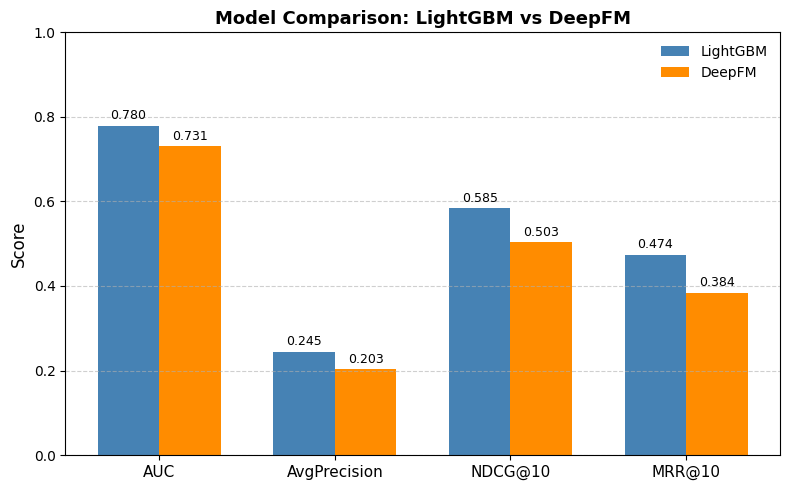

In [18]:


# Metrics and values
metrics = ["AUC", "AvgPrecision", "NDCG@10", "MRR@10"]
values = {
    "LightGBM": [0.7796, 0.2447, 0.5846, 0.4740],
    "DeepFM":   [0.7312, 0.2030, 0.5034, 0.3840],
}

# Convert to NumPy arrays for easy plotting
lightgbm_vals = np.array(values["LightGBM"])
deepfm_vals   = np.array(values["DeepFM"])

# Bar chart setup
x = np.arange(len(metrics))  # metric positions
width = 0.35                 # bar width

plt.figure(figsize=(8,5))
plt.bar(x - width/2, lightgbm_vals, width, label="LightGBM", color="steelblue")
plt.bar(x + width/2, deepfm_vals, width, label="DeepFM", color="darkorange")

# Labels and styling
plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Score", fontsize=12)
plt.title("Model Comparison: LightGBM vs DeepFM", fontsize=13, fontweight='bold')
plt.ylim(0, 1.0)
plt.legend(frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars
for i, (l, d) in enumerate(zip(lightgbm_vals, deepfm_vals)):
    plt.text(i - width/2, l + 0.015, f"{l:.3f}", ha='center', fontsize=9)
    plt.text(i + width/2, d + 0.015, f"{d:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig("/kaggle/working/model_comparison_bar.png", dpi=150)
plt.show()


 LightGBM model loaded.
Loaded 20 articles for test demo.

Top-5 Predicted Articles for Synthetic User:


,article_id,cosine_similarity,predicted_click_prob
6458,9739284,-0.012394,0.334348
3776,9572657,-0.021173,0.326266
8113,9755756,-0.023992,0.318525
1408,8905826,-0.009401,0.315106
5545,9720086,-0.018377,0.306995


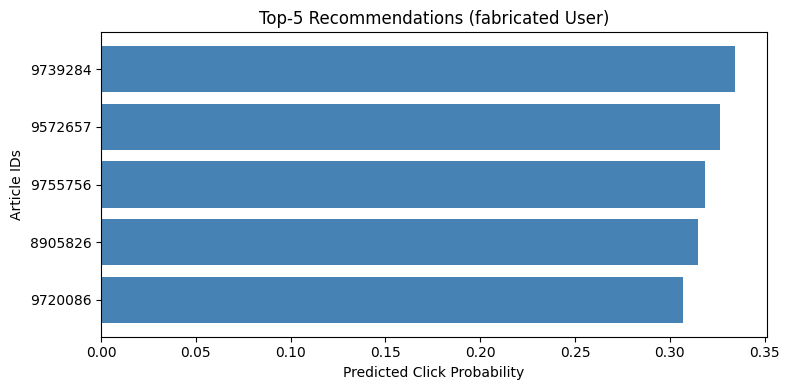

In [20]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


model = lgb.Booster(model_file="/kaggle/working/lightgbm_model.txt")
print(" LightGBM model loaded.")

# 2) Load article embeddings (sample 20)

article_emb = pd.read_parquet("/kaggle/working/embeddings_fused.parquet")
sample_articles = article_emb.sample(20, random_state=42).copy()
print(f"Loaded {len(sample_articles)} articles for test demo.")

# Fabricate or pick a user embedding

# Option A: pick a real one if available
# user_emb_df = pd.read_parquet("/kaggle/working/user_embeddings.parquet")
# user_vec = user_emb_df.sample(1)["embedding_user"].iloc[0]

# Option B: fabricate synthetic user preferences
user_vec = np.random.normal(size=len(sample_articles["embedding_fused"].iloc[0]))
user_vec = user_vec / np.linalg.norm(user_vec)

#  Compute cosine similarity between user and each article

def cosine_sim(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v) + 1e-8)

sample_articles["cosine_similarity"] = sample_articles["embedding_fused"].apply(lambda v: cosine_sim(user_vec, v))
sample_articles["inview_position"] = np.arange(len(sample_articles))  # mock feature
sample_articles["impression_size"] = len(sample_articles)
sample_articles["device_type"] = 1
sample_articles["is_sso_user"] = 0
sample_articles["is_subscriber"] = 0
sample_articles["age_filled"] = 25
sample_articles["scroll_percentage_filled"] = np.random.randint(20, 90, len(sample_articles))
sample_articles["read_time_filled"] = np.random.randint(10, 60, len(sample_articles))

# Fill required features with zeros if missing

feature_cols = get_feature_columns()
for f in feature_cols:
    if f not in sample_articles.columns:
        sample_articles[f] = 0

#  Predict with LightGBM

X_test = sample_articles[feature_cols]
sample_articles["predicted_click_prob"] = model.predict(X_test)

#  Display top recommendations

topk = sample_articles.sort_values("predicted_click_prob", ascending=False).head(5)
print("\nTop-5 Predicted Articles for Synthetic User:")
display(topk[["article_id", "cosine_similarity", "predicted_click_prob"]])

# ---------------------------
# 8) Visualize
# ---------------------------
plt.figure(figsize=(8,4))
plt.barh(topk["article_id"].astype(str), topk["predicted_click_prob"], color="steelblue")
plt.xlabel("Predicted Click Probability")
plt.ylabel("Article IDs")
plt.title("Top-5 Recommendations (fabricated User)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [21]:

#  Build full validation interactions again (fast)
val_interactions = build_interaction_table(
    behaviors_path="/kaggle/input/recommendersystem/validation/behaviors.parquet",
    history_path="/kaggle/input/recommendersystem/validation/history.parquet",
    article_emb_path="/kaggle/working/embeddings_fused.parquet",
    has_labels=True,
    is_test=False
)

# Then repeat user selection and prediction
user_id = val_interactions["user_id"].value_counts().index[0]
user_data = val_interactions[val_interactions["user_id"] == user_id].copy()


 Building user embeddings...


/tmp/ipykernel_48/1434816848.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  0.7 * merged['read_time_norm'].fillna(0) +
/tmp/ipykernel_48/1434816848.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  0.3 * merged['scroll_norm'].fillna(0)
Building user embeddings: 100%|██████████| 1562/1562 [00:02<00:00, 657.53it/s]



 Exploding behaviors...


Exploding behaviors: 100%|██████████| 25356/25356 [00:10<00:00, 2510.66it/s]


In [22]:
# Prepare features
feature_cols = get_feature_columns()
for f in feature_cols:
    if f not in user_data.columns:
        user_data[f] = 0
user_data = user_data.fillna(0)

# Predict for that user
X_user = user_data[feature_cols]
user_data["predicted_click_prob"] = model.predict(X_user)

# Compare with original (true clicks)
# Sort by predicted probability
user_data = user_data.sort_values("predicted_click_prob", ascending=False).reset_index(drop=True)

# Add columns for visualization
user_data["predicted_label"] = (user_data["predicted_click_prob"] >= 0.5).astype(int)
user_data["match"] = np.where(user_data["label"] == user_data["predicted_label"], "Correct", "Wrong")

# Show top 15 as a comparison table
print("\n Top-15 Predictions for Real User (Predicted vs Actual):")
display(user_data[["article_id_candidate", "predicted_click_prob", "predicted_label", "label", "match"]].head(15))

#  Visualize top-10 ranking
topk = user_data.head(10)
colors = [
    "red" if (r["label"]==1 and r["predicted_label"]==1)
    else "steelblue" if (r["label"]==1 and r["predicted_label"]==0)
    else "darkorange"
    for _, r in topk.iterrows()
]



 Top-15 Predictions for Real User (Predicted vs Actual):


,article_id_candidate,predicted_click_prob,predicted_label,label,match
0,9783024,0.663541,1,0,Wrong
1,9788188,0.602153,1,0,Wrong
2,9784879,0.583434,1,0,Wrong
3,9783886,0.493964,0,1,Wrong
4,9788752,0.467423,0,0,Correct
5,9783024,0.444255,0,0,Correct
6,9782652,0.431389,0,0,Correct
7,9782027,0.421646,0,0,Correct
8,9781998,0.411009,0,0,Correct
9,9781991,0.408213,0,1,Wrong
